# EE353 ASSIGNMENT 2
#### PRIYANSH SINGH
#### 22B1856
#### LINK TO THE EXPLANATORY VIDEO: 

NOTE: For uniformity, multi-dimensional variables are named using uppercase and scalars using lowercase 

In [1]:
#data handling and basic math libraries
import pandas as pd
import numpy as np

#time library for complexity analysis
import time

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Task 1 - Data matrix generation

## Function taking a generator matrix and giving a data matrix with desired correlations as output
#### Taking all the columns of the intermediate random matrix as IID sampled 

In [32]:
def gen_data_matrix(n, S):#function declaration - this function can accomodate even non numpy arrays, they will be converted inside the function
    m = np.array(S).shape[0] #extracting the number of rows in S as m
    #[1]
    RANDOM_ARR = np.zeros((n,m)) #initialising the random array as the n x m zero matrix 
    for i in range(n): #looping through the rows of RANDOM_ARR
        for j in range(m): #looping through the columns of RANDOM_ARR 
            RANDOM_ARR[i][j] = np.random.normal(0, 1) #setting each element of RANDOM_ARR as a random sample from a standard normal distribution
    
    #multiplying RANDOM_ARR with the generator matrix
    X = np.dot(RANDOM_ARR, np.array(S)) #np.dot takes the dot product
    return X

### Checking the above function for an identity generator matrix 

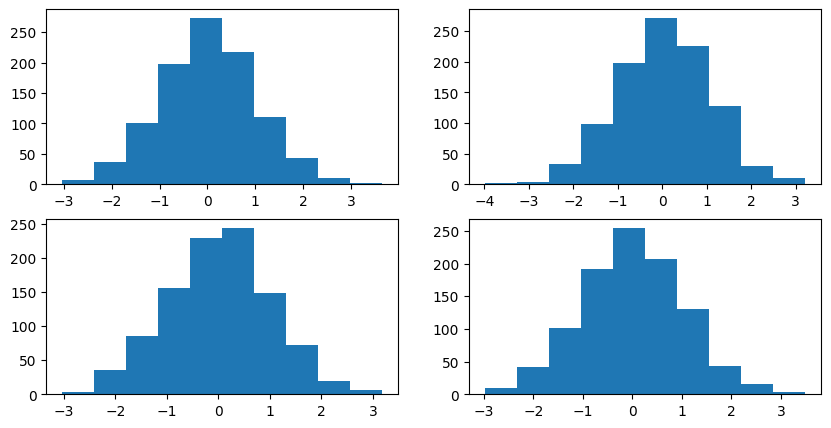

In [33]:
n = 1000 #setting the number of data points
S = np.identity(n) #setting the generator matrix as identity using numpy
X = gen_data_matrix(n, S) #calling the function over these inputs

#creating histograms to display the distribution for the first 4 columns - expected to be gaussian
plt.figure(figsize=(10,5))
for i in range(4): #looping for multiple subplots 
    plt.subplot(2, 2, i + 1) #subplot used to avpid all the histograms getting displayed on the same figure
    plt.hist(X[:,i]) #histogram of an array using plt.hist

# Task 2 - Function to generate the target vector

In [35]:
def get_target(X, W, noise_var):
    d = np.array(X).shape[1] #number of columns in X
    #dimension mismatch check
    if(len(W) != d + 1):
       #[2]
       raise RuntimeError(f"Provided weight vector is of dimension {len(W)}, expected {d+1}") #raises runtime error for dimesion mismatch
    #If dimensions match
    TARGET = np.dot(np.array(X), W[0:d]) + W[d] + np.random.normal(0, noise_var) #target calculation using dot product and adding the bias and noise
    return TARGET

### Testing the dimension mismatch condition
#### Expected output would be a Runtime Error: "Provided weight vector is of dimension 4, expected 1001"

In [36]:
get_target(X, [1,1,1,1], 0)#calling the function over X, of dimension 1000 x 1000 generated above and W of length 4

RuntimeError: Provided weight vector is of dimension 4, expected 1001

# Task 3 - Analysing the time complexity of the algorithm used in np.linalg.pinv()

In [6]:
time_taken_arr = [] #this list will store the time taken along with the matrix size
#the following loop will create random i x 10 matrices with each entry uniformly sampled from [0,1] and then will compute pinv
for i in range(10000):
    RANDOM_MATRIX_0_1 = np.random.rand(i, 10) #creates a random i x 10 matrix with each entry sampled from [0,1] 
    time_init = time.time() #this function tells time in seconds passed since January 1, 1970
    PINV_RANDOM_MATRIX_0_1 = np.linalg.pinv(RANDOM_MATRIX_0_1) #Calling the pinv function which takes some finite time to run
    time_taken_arr.append([i, time.time() - time_init]) #appending a row to the array containing i and the time elapsed

time_taken_arr = np.array(time_taken_arr) #Converting the array to a numpy array for ease of operations 
    

### Plotting the variation on a log scale plot

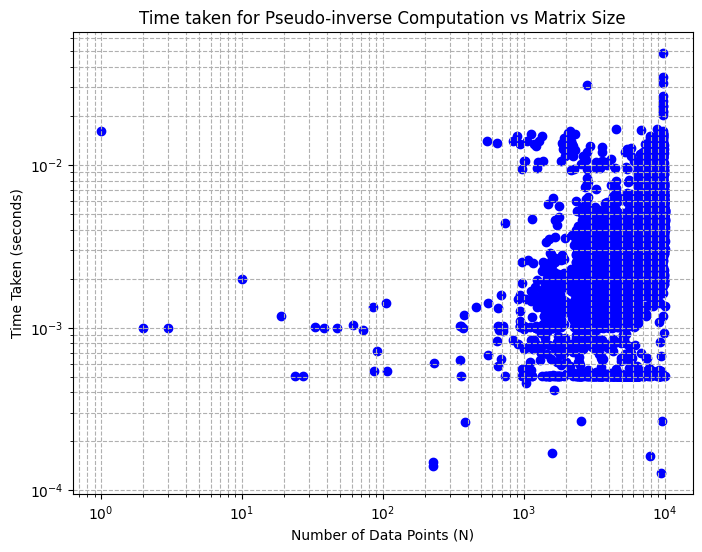

In [7]:
# Plot the results in log-log scale
plt.figure(figsize=(8, 6))
plt.scatter(time_taken_arr[:,0], time_taken_arr[:, 1], marker='o', color='b')

#[3]
# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Number of Data Points (N)')
plt.ylabel('Time Taken (seconds)')
plt.title('Time taken for Pseudo-inverse Computation vs Matrix Size')

# Show the plot
plt.grid(True, which="both", ls="--")
plt.show()


#### OBSERVATION: The time taken stays almost ocntant up until array size 1000, when the complexity starts to increase, but not monotonically, it actually oscillates and slowly drifts up. Analysing the possible reasons:  
1. Random elements : I tested the time complexity with arrays containing just ones, and such a plot was still observed, so the random assignment is not the reason.
2. Internal algorithm : The np.linalg.pinv method invokes SVD on the input matrix which has a complexity of N^2 for our case, this might be the reason, along with other computation mechanisms for the sudden jump in the time elapsed at high values of N 

#### To demonstrate the overall drift/trend in the values of the time complexity over the varying values of N after N = 1000, a window averaging over the values of the time taken can be done after N = 1000  

In [8]:
window_average = [] #this list would store the time taken values averaged over a window of 10 entries
window_size = 10 #size of the window, ie, the number of elements averaged
for i in window_size*(np.arange(int(1000/window_size), int(10000/window_size))): #looping through the time taken array to take the average     
    window_average.append([np.mean(time_taken_arr[:,0][i:i + window_size]),np.mean(time_taken_arr[:,1][i:i + window_size])]) #storing the average N and the average time taken in the window average list
window_average = np.array(window_average)#converting the list to a numpy array for ease of calculation 

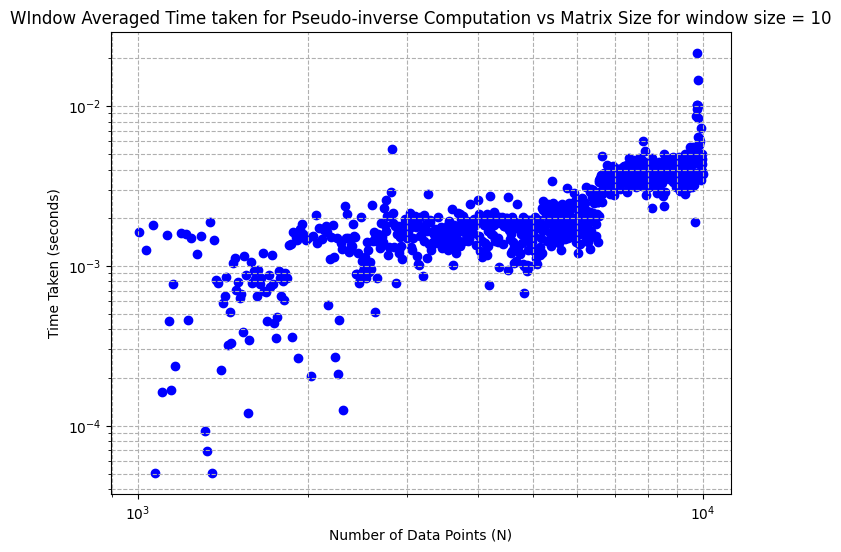

In [9]:
# Plot the results in log-log scale
plt.figure(figsize=(8, 6))
plt.scatter(window_average[:,0], window_average[:, 1], marker='o', color='b')

#[3]
# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Number of Data Points (N)')
plt.ylabel('Time Taken (seconds)')
plt.title(f"WIndow Averaged Time taken for Pseudo-inverse Computation vs Matrix Size for window size = {window_size}")

# Show the plot
plt.grid(True, which="both", ls="--")
plt.show()


# Task 4 - Normalized Root Mean Squared Error

#### NRMSE can be calculated by two different approaches:  
#### Mean normalization: NRMSE = $\frac{RMSE}{mean of target}$   
#### Range normalization: NRMSE = $\frac{RMSE}{range of target values}$
#### I will be proceesing with normalizing using the target mean

In [37]:
def nrmse(T, Y): #function declaration
    #For ease of programming, converting T and Y to numpy arrays using np.array(T) and np.array(Y)  
    rmse = np.sum((np.array(T) - np.array(Y))**2) #np.sum computes the sum of all the entries in an array 
    target_mean = np.sum(T)/len(T) #average of Target array
    nrmse = rmse/target_mean #mean normalization
    return nrmse

# Task 5 - Gradient of MSE 

#### Appending a column [1,1,1,...] to X, we'll get the expression for MSE as the following
#### MSE = $\sum_{i=1}^{n} \frac{(t_i - X_iW - noise)^2}{n}$
#### Here, W includes the bias
#### $ \nabla_W $ MSE = $\sum_{i=1}^{n} \frac{2(X_iW + noise - t_i)(X_i)}{n}$  
#### Inputs to the function: Target, Prediction and Data matrix    

In [84]:
def grad_mse(Y, T, X): #Y : predictions for all the datapoints T : Targets for all the datapoints 
    GRAD_MSE =  np.zeros((np.array(X).shape[1]) + 1) #this array of length d + 1 will be the gradient vector

    for i in range(len(T)):#looping through all the datapoints for summation 
        X_i = np.array(X[i]) #ith row of X - that is the ith datapoint
        X_i = np.append(X_i, 1) #appending 1 to the ith row to accomodate for bias in W 
        #Assuming W is of length d+1, including the bias
        GRAD_MSE = GRAD_MSE + 2*(Y[i] - T[i])*(X_i) #calculation

    GRAD_MSE = GRAD_MSE/len(T) #dividing by n for mean
    return GRAD_MSE

# Task 6, 7 - Gradient of L2 and L1 norms
## L2
#### L2 penalty = $\frac{W^TW}{2}$
#### $ \nabla_W $ L2 penalty = W 
## L1
#### L1 penalty = $\sum_{i=0}^{d-1} |W[i]|$  
#### $ \nabla_W $ L1 penalty = [sgn(W[0]), sgn(W[1]), ..., sgn(W[d-1])], where sgn(x) = -1 if x < 0 and 1 otherwise
### L1 and L2 are applied only on the weights and not the bias, so W here includes only d entries, not d+1

In [102]:
def grad_l2(W):
    return W[0:len(W) - 1] #returns the first d entries of W

def grad_l1(W):
    GRAD_L1 = [] #this list will store the gradient
    for i in range(len(W) - 1): #looping only through the first d entries
        GRAD_L1.append(1 if W[i] >= 0 else -1) #appends the signum of the weight to the list
    GRAD_L1 = np.array(GRAD_L1) #converting GRAD_L1 to a numpy array for ease of programming
    return GRAD_L1 

# Task 8 - Gradient descent

In [103]:
def grad_descent(X, T, noise_var, l2_coeff, l1_coeff, learning_rate): #Returns the best weights
    W_OLD = np.random.rand(np.array(X).shape[1] + 1) #random array of dimension d + 1
    GRADIENT_W_OLD = grad_mse(get_target(X, W_OLD, noise_var), T, X) + l2_coeff*grad_l2(W_OLD) + l1_coeff*grad_l1(W_OLD)
    W_NEW = W_OLD - learning_rate*(GRADIENT_W_OLD)
    for j in range(10):
         W_OLD = W_NEW
         GRADIENT_W_OLD = grad_mse(get_target(X, W_OLD, noise_var), T, X) + l2_coeff*grad_l2(W_OLD) + l1_coeff*grad_l1(W_OLD)
         W_NEW = W_OLD - learning_rate*(GRADIENT_W_OLD)
    return W_NEW

In [104]:
df = pd.read_csv("Customer Purchasing Behaviors.csv")

In [105]:
df.columns

Index(['user_id', 'age', 'annual_income', 'purchase_amount', 'loyalty_score',
       'purchase_frequency'],
      dtype='object')

In [106]:
data_x = df[['age', 'annual_income', 'loyalty_score']]
data_y = df['purchase_amount']

In [107]:
grad_descent(np.array(data_x), np.array(data_y), 1, 0, 0, 0.1)

ValueError: operands could not be broadcast together with shapes (4,) (3,) 

# References:  
[1]: ChatGPT prompt: How to set the underlying distribution in the random function in np.random  
[2]: ChatGPT prompt: How to set a raise error condition if my function is called on an illegal input  
[3]: ChatGPT prompt: How to set log scale in a scatter plot in pyplot  
[4]: ChatGPT prompt:  
[5]: ChatGPT prompt:   
[6]: ChatGPT prompt: 